# Course 2: Project - Task B - Manipulating the data

<a name="task-b-top"></a>
This notebook is concerned with task B.

**Contents:**
* [Imports](#task-b-imports)
* [Utilities](#task-b-utilities)
* [Data loading](#task-b-data-loading)
* [Question 1](#task-b-question-1)
* [Question 2](#task-b-question-2)
* [Question 3](#task-b-question-3)

## Imports<a name="task-e-imports"></a> ([top](#task-e-top))
---

In [439]:
# Standard library:
import collections
import enum
import functools
import math
import pathlib
import re
import typing as t
import urllib.parse

# 3rd party:
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import pandas.io.formats.style
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

# Project:
import cleanquantity
import ean
import ingredients
import tags
import utils

%matplotlib inline
register_matplotlib_converters()

## Utilities<a name="task-e-utilities"></a> ([top](#task-e-top))
---

We define a few utilities that we will use later in this notebook:

In [304]:
def profile(df: pd.DataFrame) -> pd.DataFrame:
        
    data = {
        'NA': df.apply(lambda series: series.isna().sum()),
        'NA %': df.apply(lambda series: series.isna().mean() * 100.0),
        'Non-NA': df.apply(lambda series: series.notna().sum()),
        'Non-NA %': df.apply(lambda series: series.notna().mean() * 100.0)
    }
    
    return pd.DataFrame(data)


## Data loading<a name="task-e-data-loading"></a> ([top](#task-e-top))
---

First, we load the entire cleaned-up dataset:

In [406]:
base_name = pathlib.Path.cwd().joinpath('en.openfoodfacts.org.products.clean')

In [407]:
# Load the data-types:
data_types, parse_dates = utils.load_and_amend_dtypes(base_name)

# Load the data-frame:
df = pd.read_csv(
    f'{base_name}.csv',
    header=0,
    parse_dates=parse_dates,
    dtype=data_types)

We get some general information:

In [ ]:
#df.info(verbose=True, null_counts=True)

We look at the first few rows:

In [408]:
df.head()

,code,url,creator,product_name,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,...,nutrition-score-fr_100g,nutrition-score-uk_100g,created_on_utc,last_modified_on_utc,quantity_number,quantity_unit,first_packaging_code_lat,first_packaging_code_lon,serving_number,serving_unit
0,0000000003087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,Farine de blé noir,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,...,NaN,NaN,2016-09-17 09:17:46,2016-09-17 09:18:13,1000.0,g,NaN,NaN,NaN,NaN
1,0000000004530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,14.0,2017-03-09 14:32:37,2017-03-09 14:32:37,NaN,NaN,NaN,NaN,28.0,g
2,0000000004559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,Peanuts,NaN,NaN,Torn & Glasser,torn-glasser,NaN,NaN,...,0.0,0.0,2017-03-09 14:32:37,2017-03-09 14:32:37,NaN,NaN,NaN,NaN,28.0,g
3,0000000016087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,Organic Salted Nut Mix,NaN,NaN,Grizzlies,grizzlies,NaN,NaN,...,12.0,12.0,2017-03-09 10:35:31,2017-03-09 10:35:31,NaN,NaN,NaN,NaN,28.0,g
4,0000000016094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,Organic Polenta,NaN,NaN,Bob's Red Mill,bob-s-red-mill,NaN,NaN,...,NaN,NaN,2017-03-09 10:34:13,2017-03-09 10:34:13,NaN,NaN,NaN,NaN,35.0,g


## Question 1<a name="task-b-question-1"></a> ([top](#task-b-top))
---

**Question 1:** How is the Open Food Facts project doing? In order to get a sense of how the project is doing, we want to analyze the number of unique creators per month, over the full timeline of the data.

We first create a separate data-frame with the subset that we need:

In [334]:
columns = [
    'creator',
    'created_on_utc' 
]

df_creators = df[columns]

We aggregate over time:

In [335]:
# Set the index:
df_result = df_creators.set_index('created_on_utc')

# Make sure that the entries are sorted:
df_result.sort_index()

# Find the number of unique creators per month:
df_result = df_result.resample('M').nunique()

# Reset the index:
df_result = df_result.reset_index()

# Rename the columns:
df_result = df_result.rename(columns={
    'created_on_utc': 'month_end_utc',
    'creator': 'creators'
})

Finally, we plot the result:

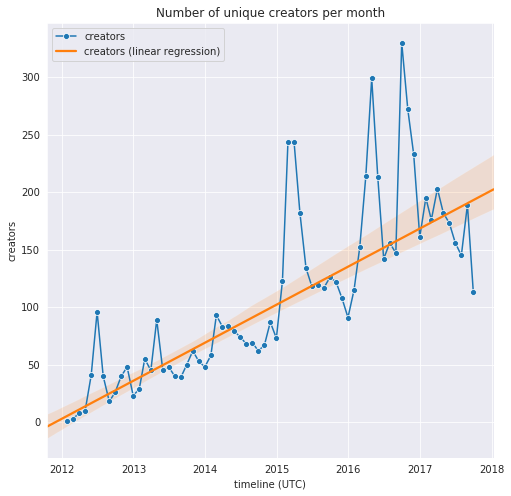

In [336]:
# For the regression plot:
df_result['month_end_utc_ordinal'] = pd.to_datetime(
    df_result['month_end_utc']).apply(lambda ts: ts.toordinal())

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.lineplot(x='month_end_utc', y='creators', data=df_result,
                 ax=ax, marker='o', legend=False)
    sns.regplot(x='month_end_utc_ordinal', y='creators', data=df_result,
                ax=ax, marker='', robust=True)
    ax.set_title('Number of unique creators per month')
    ax.set_xlabel('timeline (UTC)')
    ax.set_ylabel('creators')
    ax.legend(labels=['creators', 'creators (linear regression)'], loc='best')
plt.show()

**Comment:** Judging by this graph, the project seems to be doing reasonably well since the number of unique data creators per month has increased over time.

## Question 2<a name="task-b-question-2"></a> ([top](#task-b-top))
---

**Question 2:** What is the evolution of sugar over time? In order to get a sense of this evolution, we want to analyze the average amount of a) carbohydrates and b) the different types of carbohydrates in food products per quarter, over the full timeline of the data. We also want to focus and compare 2 markets - USA and France.

As a reminder, we have:
* Carbohydrates:
  * Sugars (simple)
  * Starches (complex)
  * Fibers (complex)
  * Polyols (reduced-calorie carbohydrates)

We first create a separate data-frame for each country with only the columms that we need:

In [337]:
columns = [
    'created_on_utc',
    'carbohydrates_100g',
    'sugars_100g',
    'starch_100g',
    'fiber_100g',
    'polyols_100g'
]


def filter_country(df: pd.DataFrame, country: str) -> pd.DataFrame:
    cond_country = df['countries_tags'].str.contains(country, na=False, regex=False)
    return df[cond_country]


df_us = filter_country(df, 'united-states')[columns]
df_fr = filter_country(df, 'france')[columns]

nrows, ncols = df_us.shape
print(f"the dataset 'us' contains {nrows} rows and {ncols} columns")
nrows, ncols = df_fr.shape
print(f"the dataset 'fr' contains {nrows} rows and {ncols} columns")

the dataset 'us' contains 173439 rows and 6 columns
the dataset 'fr' contains 129239 rows and 6 columns


We get some general information about the values in each data-frame:

In [338]:
display(profile(df_us), profile(df_fr))

,NA,NA %,Non-NA,Non-NA %
created_on_utc,0,0.000000,173439,100.000000
carbohydrates_100g,1868,1.077036,171571,98.922964
sugars_100g,13024,7.509268,160415,92.490732
starch_100g,173438,99.999423,1,0.000577
fiber_100g,33350,19.228663,140089,80.771337
polyols_100g,173434,99.997117,5,0.002883


,NA,NA %,Non-NA,Non-NA %
created_on_utc,0,0.000000,129239,100.000000
carbohydrates_100g,48463,37.498743,80776,62.501257
sugars_100g,34362,26.587949,94877,73.412051
starch_100g,129054,99.856854,185,0.143146
fiber_100g,64729,50.084727,64510,49.915273
polyols_100g,128907,99.743112,332,0.256888


As we already noticed during the clean-up (task A), only a small fraction of all rows contains information about starch and fiber, so we decide to drop the `starch_100g` and `polyols_100g` columns from our analysis.

In [339]:
columns_sugar = [
    'carbohydrates_100g',
    'sugars_100g',
    'fiber_100g',
]

We implement an utility function to perform the analysis:

In [340]:
def process(df: pd.DataFrame, frequency: str, columns: t.List[str]) -> pd.DataFrame:
    """\
    http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
    """
    # Set the index:
    df_result = df.set_index('created_on_utc')

    # Make sure that entries are sorted:
    df_result.sort_index()
    
    # Add an auxiliary column to the get the count per period:
    df_result['count'] = 1

    # Aggregate:
    agg_dict = {column: 'mean' for column in columns}
    agg_dict['count'] = 'count'
    df_result = df_result.resample('Q').agg(agg_dict)

    df_result.index.names = [f'{frequency.lower()}_utc']

    # Reset the index:
    df_result = df_result.reset_index()

    # Rename some columns:
    df_result = df_result.rename(columns={
        'created_on_utc': f'{frequency.lower()}_utc'
    })
    
    return df_result

In [341]:
df_us_result = process(df_us, 'Q', columns_sugar)
df_fr_result = process(df_fr, 'Q', columns_sugar)
display(df_us_result.head(), df_fr_result.head())

,q_utc,carbohydrates_100g,sugars_100g,fiber_100g,count
0,2012-06-30,20.713333,10.080000,2.934000,6
1,2012-09-30,70.500000,12.800000,0.000000,1
2,2012-12-31,18.450000,8.900000,1.733333,5
3,2013-03-31,32.488824,11.257143,2.795000,26
4,2013-06-30,35.542059,13.909688,2.485667,59


,q_utc,carbohydrates_100g,sugars_100g,fiber_100g,count
0,2012-03-31,31.764955,13.412523,2.254878,147
1,2012-06-30,24.618511,10.916532,2.518097,1277
2,2012-09-30,31.443432,14.534192,2.229894,683
3,2012-12-31,30.193272,13.665538,2.701584,1170
4,2013-03-31,28.314489,13.439970,2.446105,1460


We implement an utility function to plot the result. We want to display the average amount of sugar per period as well as the number of products the average is based on (an average based on a small number of products should be less reliable than an average based on a large number of products): 

In [342]:
def plot_result(df: pd.DataFrame,
                data_cols: t.List[str],
                data_labels: t.List[str],
                period_col: str, 
                period_label: str,
                amount_bound: t.Tuple[float, float],
                count_threshold: int,
                figtitle: str,
                figsize=(8,8)) -> None:
    """\
    """
    with sns.axes_style('darkgrid'):
        fig, (lax, rax) = plt.subplots(nrows=1, ncols=2, sharey=True,
                                       figsize=(8,8), gridspec_kw={'width_ratios': [4, 1]})
        
        # The left plot is for data:
        df.plot.barh(x=period_col, y=data_cols, stacked=True,
                     ax=lax, legend=True, label=data_labels)
        lax.set_xbound(amount_bound)
        lax.set_ylabel(period_label)
        lax.legend(loc='upper left')
        lax.set_title('Avererage amount (g)')
         
        # The right plot is for the number of products:
        df.plot.barh(x=period_col, y='count',
                     ax=rax, logx=True, legend=False)
        # Set individual bar labels:
        for p in rax.patches:
            rax.text(p.get_width()+10.0, p.get_y()+.1, str(p.get_width()), color='dimgrey')
            if p.get_width() < count_threshold:
                p.set_color('red')
        rax.set_title('# products')
        
        # Since the y-axis is shared, we need to do this here:
        lax.set_yticklabels(df[period_col].dt.strftime('%Y-%m-%d').to_list())
        
        fig.suptitle(figtitle, y=0.95)
plt.show()

We first display the result for carbohydrates (and higlight periods with less than 20 products):

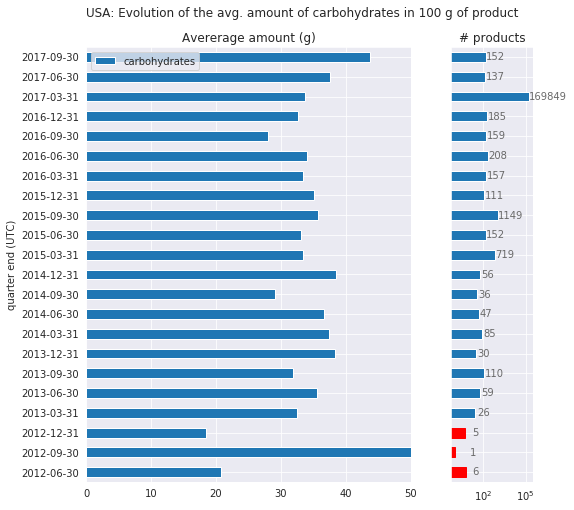

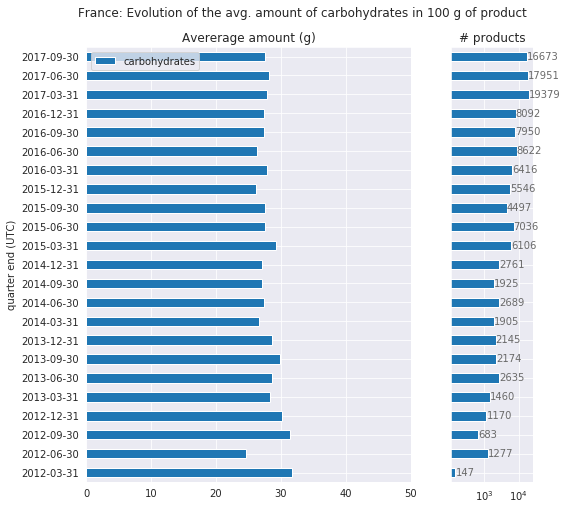

In [343]:
plot_result(df_us_result, ['carbohydrates_100g'], ['carbohydrates'], 'q_utc','quarter end (UTC)', (0, 50), 20,
     'USA: Evolution of the avg. amount of carbohydrates in 100 g of product')
plot_result(df_fr_result, ['carbohydrates_100g'], ['carbohydrates'], 'q_utc','quarter end (UTC)', (0, 50), 20,
     'France: Evolution of the avg. amount of carbohydrates in 100 g of product')

**Comment:** The first thing we notice is that products in the USA contain on average more carbohydrates than products in France. Regarding the evolution (ignoring periods with less than 20 products): In the USA, the amount seems to increase slightly. In France, it seems to stagnate.

We finally display the result for sugars and fiber (and higlight periods with less than 20 products):

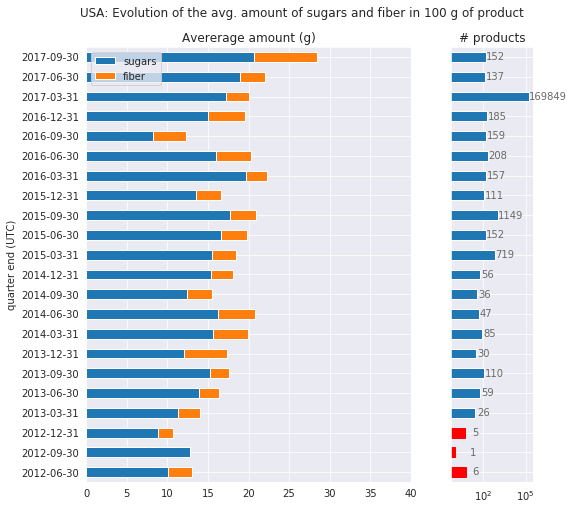

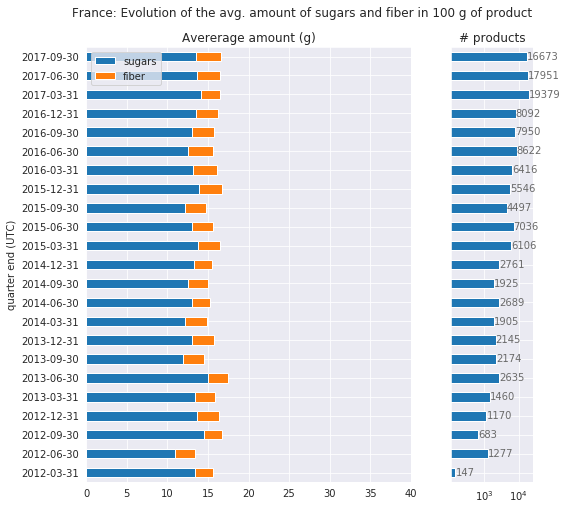

In [344]:
plot_result(df_us_result, ['sugars_100g', 'fiber_100g'], ['sugars', 'fiber'], 'q_utc','quarter end (UTC)', (0, 40), 20,
     'USA: Evolution of the avg. amount of sugars and fiber in 100 g of product')
plot_result(df_fr_result, ['sugars_100g', 'fiber_100g'], ['sugars', 'fiber'], 'q_utc','quarter end (UTC)', (0, 40), 20,
     'France: Evolution of the avg. amount of sugars and fiber in 100 g of product')

**Comment:** Food products in the USA contain on average more sugars and fiber than products in France (which is consistent with the result for carbohydrates above). Regarding the evolution (ignoring periods with less than 20 products): In the USA, the amounts of sugars and fiber seem to increase over time. In France, they seem to stagnate.

## Question 3<a name="task-b-question-3"></a> ([top](#task-b-top))
---

**Question 3:** We want to ...

In [409]:
# Candidates:
# main_category_en
# pnns_groups_1
# pnns_groups_1

series = df['main_category_en'].value_counts()
series[series > 100]

Plant-based foods and beverages    22935
Beverages                          14191
Sugary snacks                      12728
Dairies                             8091
Groceries                           6471
Meats                               5394
Fresh foods                         3573
Meals                               3005
Spreads                             2443
Salty snacks                        2384
Fruit juices                        2383
Canned foods                        1941
Frozen foods                        1715
Seafood                             1695
Desserts                            1382
Fats                                 772
Sandwiches                           727
Sweeteners                           622
Farming products                     568
Baby foods                           559
Fruit juices and nectars             436
Breakfasts                           358
Dietary supplements                  337
Dried products                       328
Vinegars        

In [410]:
df['pnns_groups_1'].value_counts()

unknown                    43542
Sugary snacks              14738
Beverages                  13464
Milk and dairy products    10745
Cereals and potatoes       10071
Fish Meat Eggs              9466
Composite foods             7971
Fat and sauces              7112
Fruits and vegetables       6760
Salty snacks                3299
fruits-and-vegetables       1097
sugary-snacks                618
cereals-and-potatoes          19
salty-snacks                   1
Name: pnns_groups_1, dtype: int64

In [411]:
df['pnns_groups_2'].value_counts()

unknown                             43542
Non-sugared beverages                7280
One-dish meals                       6495
Sweets                               5681
Biscuits and cakes                   5507
Cereals                              4683
Cheese                               4560
Dressings and sauces                 4519
Milk and yogurt                      4269
Processed meat                       3834
Alcoholic beverages                  3607
Chocolate products                   3550
Vegetables                           3158
Fish and seafood                     3066
Sweetened beverages                  2981
Fats                                 2593
Appetizers                           2464
Fruits                               2419
Fruit juices                         2349
Bread                                2336
Meat                                 1948
Breakfast cereals                    1759
Legumes                              1096
vegetables                        

In [412]:
(df['pnns_groups_2'].notna() & df['pnns_groups_1'].isna()).sum()

3681

In [413]:
(df['pnns_groups_2'].isna() & df['pnns_groups_1'].notna()).sum()

0

In [414]:
def normalize_pnns(group: str) -> str:
    if pd.isna(group):
        return group
    parts = group.lower().split()
    return '-'.join(parts)
    

df['pnns_groups_1'] = df['pnns_groups_1'].apply(normalize_pnns)

In [415]:
df['pnns_groups_1'].value_counts()

unknown                    43542
sugary-snacks              15356
beverages                  13464
milk-and-dairy-products    10745
cereals-and-potatoes       10090
fish-meat-eggs              9466
composite-foods             7971
fruits-and-vegetables       7857
fat-and-sauces              7112
salty-snacks                3300
Name: pnns_groups_1, dtype: int64

In [416]:
columns = [
    'pnns_groups_1',
    'ingredients_text'
]


def filter_country(df: pd.DataFrame, country: str) -> pd.DataFrame:
    is_country = df['countries_tags'].str.contains(country, na=False, regex=False)
    df_country = df[is_country & df['ingredients_text'].notna()]
    return df_country


df_us = filter_country(df, 'united-states')[columns]
df_fr = filter_country(df, 'france')[columns]

nrows, ncols = df_us.shape
print(f"the dataset 'us' contains {nrows} rows and {ncols} columns")
nrows, ncols = df_fr.shape
print(f"the dataset 'fr' contains {nrows} rows and {ncols} columns")

the dataset 'us' contains 171606 rows and 2 columns
the dataset 'fr' contains 86673 rows and 2 columns


In [417]:
df_us['pnns_groups_1'].notna().sum()

2860

In [418]:
df_fr['pnns_groups_1'].notna().sum()

84497

In [419]:
def partition(df: pd.DataFrame, by_col: str) -> t.List[t.Tuple[str, pd.DataFrame]]:
    result = []
    categories = df[by_col].unique()
    for category in categories:
        if pd.isna(category):
            continue
        else:
            part = df[df[by_col] == category]
            result.append((category, part))
    return result

In [420]:
parts_us = partition(df_us, 'pnns_groups_1')
parts_fr = partition(df_fr, 'pnns_groups_1')

for part in parts_us:
    part_cat, part_df = part
    nrows, ncols = part_df.shape
    print(f"the dataset 'parts_us/{part_cat}' contains {nrows} rows and {ncols} columns")
    
for part in parts_fr:
    part_cat, part_df = part
    nrows, ncols = part_df.shape
    print(f"the dataset 'parts_fr/{part_cat}' contains {nrows} rows and {ncols} columns")

the dataset 'parts_us/unknown' contains 892 rows and 2 columns
the dataset 'parts_us/composite-foods' contains 32 rows and 2 columns
the dataset 'parts_us/fat-and-sauces' contains 507 rows and 2 columns
the dataset 'parts_us/sugary-snacks' contains 210 rows and 2 columns
the dataset 'parts_us/beverages' contains 534 rows and 2 columns
the dataset 'parts_us/milk-and-dairy-products' contains 132 rows and 2 columns
the dataset 'parts_us/cereals-and-potatoes' contains 360 rows and 2 columns
the dataset 'parts_us/fish-meat-eggs' contains 63 rows and 2 columns
the dataset 'parts_us/salty-snacks' contains 78 rows and 2 columns
the dataset 'parts_us/fruits-and-vegetables' contains 52 rows and 2 columns
the dataset 'parts_fr/cereals-and-potatoes' contains 6230 rows and 2 columns
the dataset 'parts_fr/beverages' contains 8733 rows and 2 columns
the dataset 'parts_fr/sugary-snacks' contains 10508 rows and 2 columns
the dataset 'parts_fr/unknown' contains 27138 rows and 2 columns
the dataset 'part

In [421]:
# We get the ingredients using task c:

In [422]:
# Order matters due to substrings:
delims_en = ['and/or', 'or/and', 'and', 'or']
delims_fr = ['et/ou', 'ou/et', 'et',  'ou']

In [423]:
def parts_to_ingredients(parts: t.List[t.Tuple[str, pd.DataFrame]], delims: t.List[str]) -> t.List[t.Tuple[str, pd.DataFrame]]:
    result = []
    for part in parts:
        part_cat, part_df = part
        ingredients_df = ingredients.texts_to_ingredients_df(part_df['ingredients_text'], delims)
        ingredients_df = ingredients.reconcile_composite(ingredients_df, 0.5)
        result.append((part_cat, ingredients_df))
    return result

In [424]:
df_us_ingredients = parts_to_ingredients(parts_us, delims_en)

In [425]:
df_fr_ingredients = parts_to_ingredients(parts_fr, delims_fr)

In [434]:
def top_n(parts: t.Tuple[str, pd.DataFrame], n: int, oil: str) -> t.List[t.Tuple[str, pd.DataFrame, int]]:
    result = []
    for part in parts:
        part_cat, part_df = part
        # Keep only ingredients with oil:
        oil_df = part_df[part_df.index.str.contains(oil, na=False, regex=False)]
        # Sort by count in descending order:
        oil_df = oil_df.sort_values(by='count', ascending=False)
        # Ignore "composite" ingredients (e.g. "vegetable oil"):
        oil_df = oil_df[~oil_df['is_composite']]
        # Compute prevalence:
        oil_df['prevalence'] = oil_df['count'] / oil_df['count'].sum() * 100.0
        # Top N:
        oil_df = oil_df.head(n)[['count', 'prevalence']]
        oil_total = oil_df['count'].sum()
        result.append((part_cat, oil_df, oil_total))
    return result

In [435]:
top10_us = top_n(df_us_ingredients, 10, 'oil')
top10_fr = top_n(df_fr_ingredients, 10, 'huile')

In [436]:
df_pnns_us = df_us.groupby(by='pnns_groups_1').count().rename(columns={'ingredients_text': 'count'})
df_pnns_us = df_pnns_us.sort_values(by='count', ascending=False)
df_pnns_us['fraction'] = df_pnns_us['count'] / df_pnns_us['count'].sum()

df_pnns_fr = df_fr.groupby(by='pnns_groups_1').count().rename(columns={'ingredients_text': 'count'})
df_pnns_fr = df_pnns_fr.sort_values(by='count', ascending=False)
df_pnns_fr['fraction'] = df_pnns_fr['count'] / df_pnns_fr['count'].sum()

display(df_pnns_us, df_pnns_fr)

,count,fraction
pnns_groups_1,,
unknown,892,0.311888
beverages,534,0.186713
fat-and-sauces,507,0.177273
cereals-and-potatoes,360,0.125874
sugary-snacks,210,0.073427
milk-and-dairy-products,132,0.046154
salty-snacks,78,0.027273
fish-meat-eggs,63,0.022028
fruits-and-vegetables,52,0.018182


,count,fraction
pnns_groups_1,,
unknown,27138,0.321171
sugary-snacks,10508,0.124359
beverages,8733,0.103353
fish-meat-eggs,7088,0.083885
milk-and-dairy-products,6928,0.081991
composite-foods,6352,0.075174
cereals-and-potatoes,6230,0.073730
fruits-and-vegetables,4778,0.056546
fat-and-sauces,4536,0.053682


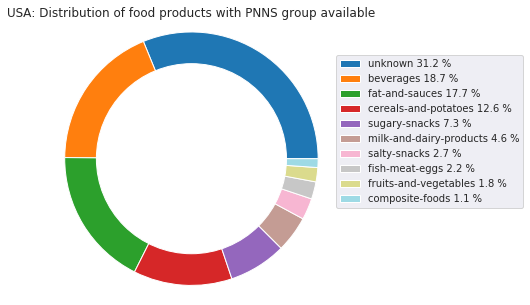

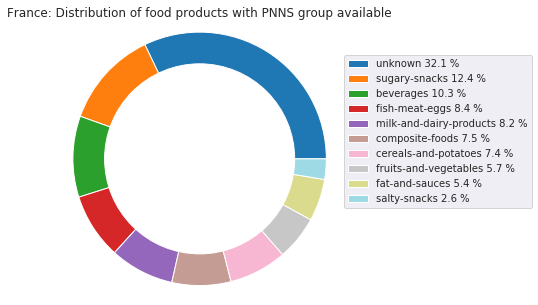

In [437]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


def plot_pnns_distribution(df: pd.DataFrame, title: str) -> None:
    with sns.axes_style('darkgrid'):
        cmap = get_cmap(len(df), 'tab20')
        fig, ax = plt.subplots(figsize=(5,5))
        ax = df.plot.pie(y='fraction', label='', labels=None, shadow=False, ax=ax, cmap=cmap)
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        # Cosmetic hack to get a doughnut pie:
        circle = plt.Circle(xy=(0,0), radius=0.75, facecolor='white')
        ax.add_artist(circle)
        labels = [f"{index} {row['fraction'] * 100:.1f} %" for index, row in df.iterrows()]
        plt.legend(labels=labels, bbox_to_anchor=(1,0.9))
        ax.set_title(title)
    plt.show()


plot_pnns_distribution(df_pnns_us, 'USA: Distribution of food products with PNNS group available')
plot_pnns_distribution(df_pnns_fr, 'France: Distribution of food products with PNNS group available')

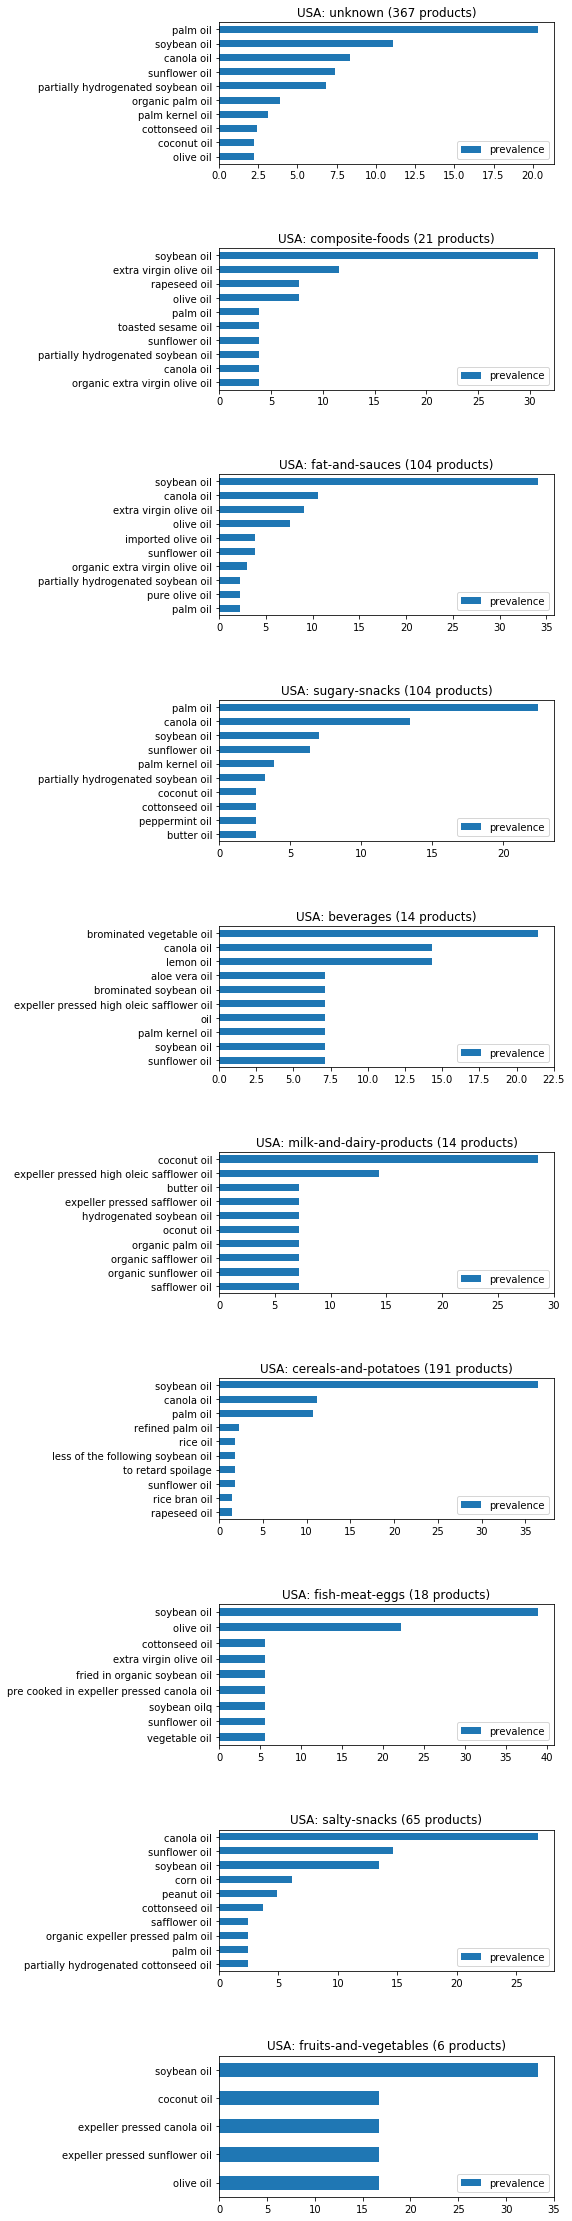

In [445]:
def plot_oils(topN: t.List[t.Tuple[str, pd.DataFrame, int]], prefix: str) -> None:
    ncols = 1
    nrows = math.ceil(len(top10_us) / ncols)
    fig = plt.figure(figsize=(6, nrows * 4))
    grid = plt.GridSpec(nrows, ncols, wspace=0.4, hspace=0.6)
    for i, part in enumerate(top10_us):
        row, col = i // ncols, i % ncols
        ax = fig.add_subplot(grid[row, col])
        part_cat, part_df, part_total = part
        ax.set_title(f'{prefix}: {part_cat} ({part_total} products)')
        part_df[['prevalence']].plot.barh(y='prevalence', ax=ax)
        ax.invert_yaxis()
        ax.set_ylabel('')
        
plot_oils(top10_us, 'USA')

**Comment:** With a few exceptions, the oils that top the chart are mass-produced and/or from GMO crops and/or known to have to adverserial health effects (and there are ethical concerns around [palm oil](https://perfectketo.com/what-is-palm-oil/)): [soybean oil](https://perfectketo.com/soybean-oil/), [brominated vegetable oil](https://www.theguardian.com/business/2014/may/06/brominated-vegetable-oil-bvo-additive-negative-health-coca-cola) and [canola oil](https://perfectketo.com/canola-oil/).

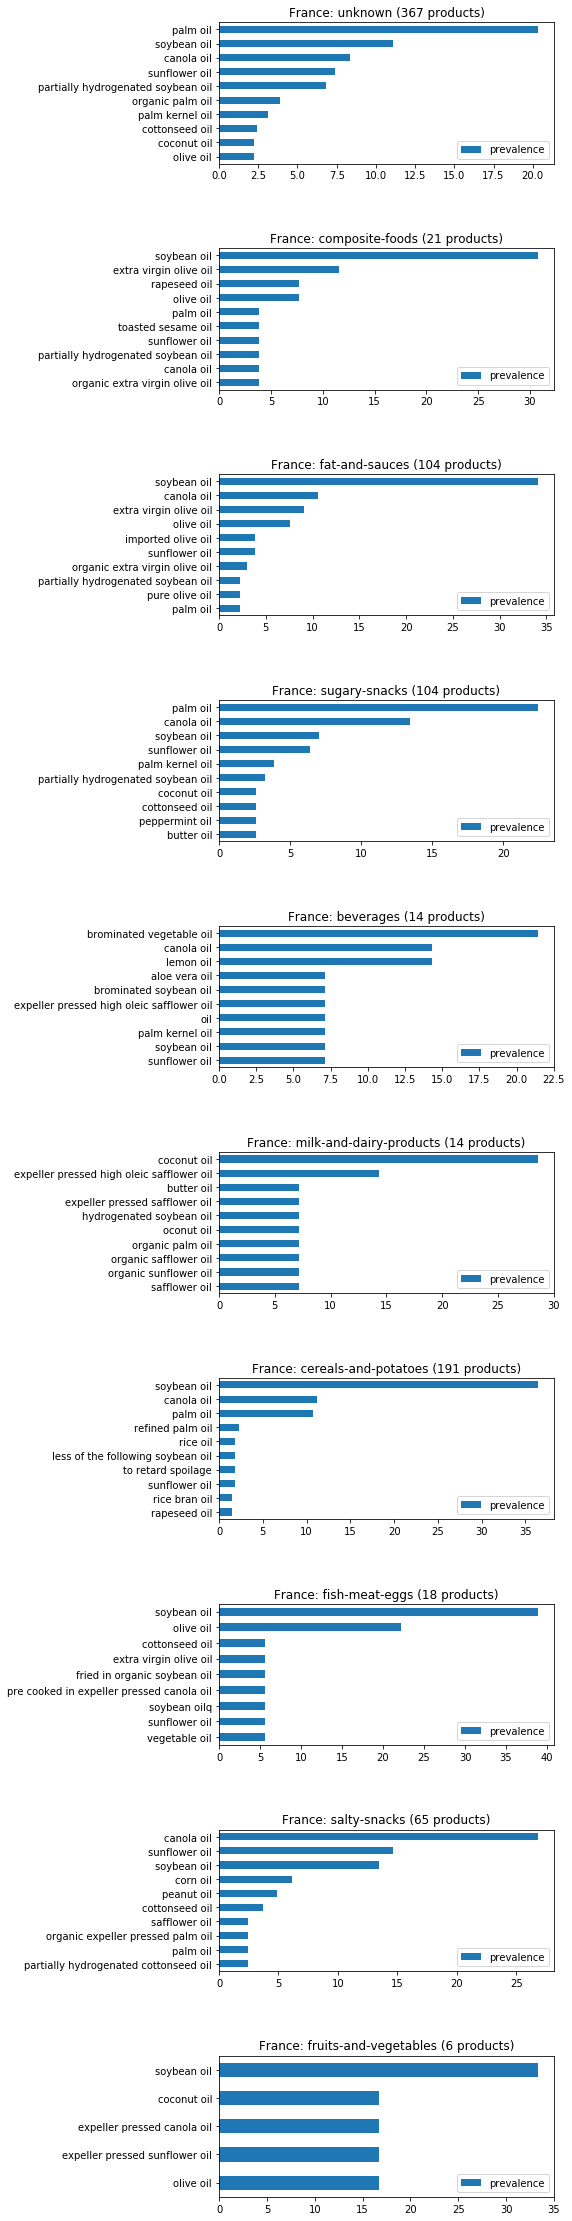

In [446]:
plot_oils(top10_fr, 'France')

**Comment:** The same comments applies for France.